# Machine Learning Project 2

In [1]:
# Imports
import pandas as pd
import numpy as np

---
## Generic Functions
Here we define all the functions to be used.

### 1. Data Loading

In [2]:
def load_data(data_path, pos_file, neg_file, size=1_250_000): 

    # positive
    pos = pd.read_table(data_path+pos_file, sep='.\n', names=['tweet'], engine='python')
    pos['label']=1
    print(f"Loaded POS data, correctly interpreted 1-tweet-per-line fashion : {pos.shape[0]==size}")

    # negative
    neg = pd.read_table(data_path+neg_file, sep='.\n', names=['tweet'], engine='python')
    neg['label']=-1
    print(f"Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : {neg.shape[0]==size}")

    # Data sizes
    print(f"Number of tweets : (POS) {pos.shape[0]} (NEG) {neg.shape[0]}\n")

    # Merge datasets to get a complete training set
    tweets = pos.append(neg)
    return tweets

In [3]:
from glove_helper import concatenate

def load_embeddings_and_vocab(embeddings_loc, embeddings_path, vocab_loc, divided=False) :
    
    ## Load word embeddings and vocabulary to compute word vectors of tweets -----------------------------------
    
    # Load word embeddings
    embeddings=None
    if divided : 
        embeddings = concatenate(embeddings_files, embeddings_path)
    else :
        embeddings = np.load(embeddings_path+embeddings_loc)
    print(f'Loaded word embeddings in structure of type {type(embeddings)}.')

    # Loading vocab
    words = pd.read_table(vocab_loc, sep='.\n', names=['word'], engine='python', squeeze=True, na_values=np.nan)
    print(f'Loaded word vocabulary in structure of type {type(words)}.')

    # Check that the vocabulary encompasses all embedded words
    print(f'\nBoth the embeddings and the vocabulary are same length :  {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Clean the data --------------------------------------------------------------------------------------------

    # Drop NaN values in vocab
    nas = words.isna()
    words.dropna(inplace=True)
    # Drop NaN words in embeddings
    embeddings = np.delete(embeddings, nas[nas].index.values, axis=0)
    
    print(f'NaN values were dropped in both tables: {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Process data ---------------------------------------------------------------------------------------------
    
    # Index by words for faster index-for-word search
    words = pd.DataFrame(data=words.index, index=words.values)
    embeddings = pd.DataFrame(embeddings, index=words.index)
    
    return embeddings, words

### 2. Data Resampling

In [4]:
from sklearn.utils import resample

def resample_data(data, size, label=1, seed=None) :
    # Get pos and neg datasets
    pos, neg = data.loc[data['label']==label], data.loc[data['label']!=label]
    
    # Get samples balanced by classes
    n = int(size/2)
    pos_ = resample(pos, n_samples=n, replace=False, random_state=seed)
    neg_ = resample(neg, n_samples=n, replace=False, random_state=seed)
    
    # reform dataset
    data_ = pos_.append(neg_)

    return data_

### 3. Data Embedding

In [64]:
def word_vector(tweet, embeddings, embeddings_dim, vocab, agg_func=None):
    """
    Creates the feature vector corresponding to the tweet.
    To do so, computes the mean of the word embeddings corresponding to the vocabulary words in the tweet.
    
    Parameters 
    ----------
    tweet : str
        Input tweet from which the word vector is created.
    """
    split_by_words = tweet.split()
    embed_list = []
    
    # Get words in tweet that are in vocab
    # Get embeddings for these words
    for w in split_by_words:
        if w in vocab.index :
            embed_list.append(  embeddings.loc[w].values  )
            
    if agg_func is None :
        agg_func = lambda x : np.mean(x, axis=0)
    
    result = None
    # If no vocab word create an empty vector for the tweet
    if not embed_list :
        result = np.zeros(embeddings_dim)
        
    # Else aggregate the word embeddings
    else :
        result = agg_func(embed_list)
    
    # Be sure to output a list to store in dataframe
    if type(result) is not list:
        result = result.tolist()
    
    return result

In [6]:
from glove_helper import concatenate

def load_word_vectors(file_path, file_loc, divided=False): 
    # Load pre-computed word vectors file
    precomputed = None
    if divided :
        print('Loading from divided dataset...')
        precomputed = concatenate(word_vectors_files, file_path)
    else : 
        precomputed = np.load(file_path+file_loc, allow_pickle=True)
        
    precomputed = pd.DataFrame(precomputed, columns=['index', 'label', 'mean_embed'])
    print('Successfully loaded from file!')
    
    return precomputed

In [67]:
from project2_helper import isAdmin, parallelize

def compute_word_vectors(data, embeddings, embeddings_dim, vocab, agg_func=None) :
    data = data.copy()
    
    # compute function to run on tweets
    func = lambda t : word_vector(t, embeddings, embeddings_dim, vocab, agg_func=agg_func)
    
    if isAdmin():
        print('Process is run as admin. Running parallelized computation...')
        data['mean_embed']= parallelize(data['tweet'], func)
    else : 
        print('Process is not run as admin. Cannot run parallelized setting, running as sequential...')
        data['mean_embed']= data['tweet'].map(func)

    return data

In [8]:
def save_word_vectors(data, file_path, ending=None):
    
    # Get word vectors information
    word_vectors = data[['label', 'mean_embed']].reset_index()
    dim = len(word_vectors.loc[0, 'mean_embed'])
    
    # Name file to format : path/word_vectors_xxnsamplesxx_xxembeddimxx_ending_npy
    name = file_path + 'word_vectors_' + str(data.shape[0]) + '_' + str(dim)
    # Add ending if requested
    if ending is not None :
        name = name+'_'+str(ending)
    
    # save data
    np.save(name, word_vectors)
    
    return True

### 4. Data Pre-processing

In [9]:
from sklearn.model_selection import train_test_split

def split_dataset(data, test_size=0.25) : 

    # Split into training and testing data
    train, test = train_test_split(data, test_size=test_size)
    print(f"Local training set size : {train.shape[0]}.")
    print(f"Local testing set size : {test.shape[0]}.\n")
     
    # Create features and labels datasets
    xtrain, ytrain = np.array(train.mean_embed.tolist()), np.array(train.label.to_list())
    xtest, ytest = np.array(test.mean_embed.tolist()), np.array(test.label.tolist())

    print(f'Training sample shape: {xtrain.shape[1:]}')
    print(f'Testing sample shape: {xtest.shape[1:]}')
    
    return xtrain, ytrain, xtest, ytest

In [36]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def preprocess(X) :
    x=X.copy()
    
    ## Standardize data
    # If features are list of features of different sizes, standardization has to be made list-wise
    if len(np.array(x).shape) == 1 : 
        x = np.array([ StandardScaler().fit_transform(a) for a in x ])
    else :
        x = StandardScaler().fit_transform(x)
    
    ## TODO Polynomial features and interactions
    
    ## other data preprocessing
    
    return x

### 5. Generate submission

In [11]:
# To format the testing data
def extract_tweet(tweet):
    return tweet.split(",", 1)[1]

In [12]:
def get_test_data(data_path, test_file='test_data.txt') :
    # Load the testing data
    test = pd.read_fwf(data_path+test_file, sep="\n", header=None)
    test = test.rename(columns={0:'tweet', 1:'na1', 2:'na2'})

    # Reformating it for submission
    test.index = test.index+1 # Format asked by AI Crowd
    test = test['tweet'].map(extract_tweet).to_frame()

    return test

In [13]:
# Creating submission file
import csv
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})

In [86]:
# Base parameters

### Loading
data_path = '../data/'
pos_data = 'train_pos_full.txt'
neg_data = 'train_neg_full.txt'

precomputed_path = '../precomputed_data/'
embeddings_file = 'embeddings_full_10epoch_100dim.npy'
vocab_loc = '../data/vocab_cut.txt'

embeddings_dim_info = 100
data_size = 100_000

word_vectors_files = ['word_vectors_100000_100_part1.npy',
                     'word_vectors_100000_100_part2.npy']
divided_word_vectors = True

---
## Data pre-training

In [80]:
# Load data
tweets = load_data(data_path, pos_data, neg_data)
embeddings, vocab = load_embeddings_and_vocab(embeddings_file, precomputed_path, vocab_loc)

# Resample data
tweets_ = resample_data(tweets, data_size, seed=1)

Loaded POS data, correctly interpreted 1-tweet-per-line fashion : True
Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : True
Number of tweets : (POS) 1250000 (NEG) 1250000

Loaded word embeddings in structure of type <class 'numpy.ndarray'>.
Loaded word vocabulary in structure of type <class 'pandas.core.series.Series'>.

Both the embeddings and the vocabulary are same length :  True
Embeddings: (101298, 100), vocab: (101298,)
NaN values were dropped in both tables: True
Embeddings: (101296, 100), vocab: (101296,)


In [81]:
# Load word vectors
tweets_ = load_word_vectors(
    precomputed_path, 
    word_vector_files, 
    divided=divided_word_vectors)

# Useless here (for demonstration purposes in case of computation and not loading)
save_word_vectors(tweets_, precomputed_path)

Loading from divided dataset...
Successfully loaded from file!


True

In [83]:
# Train-test split data
xtrain_, ytrain_, xtest_, ytest_ = split_dataset(tweets_)

# Pre-process training set
xtrain_ = preprocess(xtrain_)
xtest_ = preprocess(xtest_)

Local training set size : 75000.
Local testing set size : 25000.

Training sample shape: (100,)
Testing sample shape: (100,)


In [85]:
# Importing functions to estimate model efficiency
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

### Models Training
* Linear Regression
* Logistic Regression
* SVM
* Neural Networks

In [23]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

classifiers = dict()

In [24]:
%%time 
# Linear Regression
name = 'Linear Model'

linear_classifier = LinearRegression().fit(xtrain_, ytrain_)
score = linear_classifier.score(xtest_, ytest_)

classifiers[name] = (linear_classifier, score)

print(f"R2 score for {name} is {score}.")

R2 score for Linear Model is 0.03472532355713376.
Wall time: 360 ms


In [25]:
%%time 
# Logistic Regression
name = 'Logistic Regression'

logistic_classifier = LogisticRegression().fit(xtrain_, ytrain_)
score = logistic_classifier.score(xtest_, ytest_)

classifiers[name] = (logistic_classifier, score)

print(f"R2 score for {name} is {score}.")

# Logistic Regression using Crossvalidation
name = 'Logistic Regression using cross-validation'

logisticCV_classifier = LogisticRegressionCV().fit(xtrain_, ytrain_)
score = logisticCV_classifier.score(xtest_, ytest_)

classifiers[name] = (logisticCV_classifier, score)

print(f"R2 score for Logistic Regression model using cross-validation is {score}.")

R2 score for Logistic Regression is 0.57756.
R2 score for Logistic Regression model using cross-validation is 0.57744.
Wall time: 3.34 s


In [26]:
# Compute predictions
predtest_ = logistic_classifier.predict(xtest_)

report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.56583   0.68774   0.62086     12573
         neg    0.59601   0.46608   0.52310     12427

    accuracy                        0.57756     25000
   macro avg    0.58092   0.57691   0.57198     25000
weighted avg    0.58083   0.57756   0.57226     25000



In [27]:
# Compute predictions
predtest_ = logisticCV_classifier.predict(xtest_)

report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.56570   0.68790   0.62085     12573
         neg    0.59592   0.46568   0.52281     12427

    accuracy                        0.57744     25000
   macro avg    0.58081   0.57679   0.57183     25000
weighted avg    0.58072   0.57744   0.57211     25000



In [28]:
%%time 
# Support Vector Machines
name = 'SVM classifier'

SVM_classifier = LinearSVC().fit(xtrain_, ytrain_)
score = SVM_classifier.score(xtest_, ytest_)

classifiers[name] = (SVM_classifier, score)

print(f"R2 score for {name} model is {score}.")

R2 score for SVM classifier model is 0.57744.
Wall time: 35.4 s


C:\Users\Nico\.conda\envs\ada\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [29]:
# Compute predictions
predtest_ = SVM_classifier.predict(xtest_)

report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.56659   0.67979   0.61805     12573
         neg    0.59395   0.47389   0.52717     12427

    accuracy                        0.57744     25000
   macro avg    0.58027   0.57684   0.57261     25000
weighted avg    0.58019   0.57744   0.57287     25000



In [30]:
%%time
#### BASELINE : Neural Networks

# Neural Network
name = 'Neural Network'

nn_classifier = MLPClassifier().fit(xtrain_,ytrain_)
score = nn_classifier.score(xtest_,ytest_)

classifiers[name] = (nn_classifier, score)

print(f"R2 score for {name} classifier is {score}.")

R2 score for Neural Network classifier is 0.60476.
Wall time: 1min 37s


C:\Users\Nico\.conda\envs\ada\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
# Compute predictions
predtest_ = nn_classifier.predict(xtest_)

metrics = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5, output_dict=True)
report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.60043   0.64002   0.61960     12573
         neg    0.60976   0.56908   0.58872     12427

    accuracy                        0.60476     25000
   macro avg    0.60510   0.60455   0.60416     25000
weighted avg    0.60507   0.60476   0.60425     25000



In [195]:
# Save baseline results
path = '../results/'
name = path+'metrics_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'_baseline'
np.save(name, metrics)

### Custom models
Let us implement a custom model following the paper $\text{Text Classification with Deep Neural Networks}$ by *Maaz Amajd et al.* from Microsoft.

#### Recompute word vectors datasets
The convolutionnal Neural Network uses a matrix as input format. Here we use a matrix of words vectors representing the tweet.

In [74]:
tweets_cnn = get_word_vectors(tweets_, embedding_method='BOW', recompute=True)

Could not load word vectors from file...
Recomputing word vectors...
Process is not run as admin. Cannot run parallelized setting, running as sequential...


In [64]:
save_word_vectors(tweets_cnn, ending='cnn')
tweets_cnn

,tweet,label,mean_embed
index,,,
1193381,i cannot wait to party with <user> tonight,1,"[[0.006390639092777149, -0.002517977760506535,..."
644929,haha she talking shit but don't know me . gosh...,1,"[[0.095365011208915, -0.002271404137185445, 0...."
578303,"<user> excellent , as long as he keeps a bit o...",1,"[[0.021176976452678558, 0.007691384674272959, ..."
525309,<user> i'll be in mi on sunday ... i want to c...,1,"[[0.021176976452678558, 0.007691384674272959, ..."
34941,getting told you look like the person that dri...,1,"[[0.07722609727291953, -0.015988683796022186, ..."
...,...,...,...
1159713,<user> hey ! ! what time's your recital ? turn...,-1,"[[0.021176976452678558, 0.007691384674272959, ..."
249113,i miss being a kid . no one cared how you dres...,-1,"[[0.006390639092777149, -0.002517977760506535,..."
913236,just cannot understand how to work tumblr prop...,-1,"[[0.06250523629347589, -0.01246092651515487, 0..."


In [94]:
xtrain_cnn, ytrain_cnn, xtest_cnn, ytest_cnn = prepare_data(tweets_cnn)

Local training set size : (75000, 3).
Local testing set size : (25000, 3).

Training set first sample:
 [[0.03874826280722202, -0.0226154273381748, 0.06331501800493958, -0.05300686099727286, -0.02604800050298649, -0.06584109852584337, -0.008828779663752315, -0.10206945408357572, -0.00353245552938762, -0.029851338185586506, -0.0332773668685895, -0.0772952293011356, -0.028125405154649213, -0.07623803516338871, 0.02133121024922275, 0.02422468594373341, 0.01366152352805924, -0.02749200397469116, 0.09053584800823926, -0.023833276378709092, 0.004043477932097031, -0.05621087884414685, 0.0526542836005664, 0.045542285624793066, -0.033528027208590556, -0.017383583133306613, -0.03443335386155496, -0.10966482189803363, 0.04206032044073065, -0.07445478974047048, 0.007670329872138221, 0.0509657715676167, -0.014440089971403428, 0.11515830005637248, 0.10204113604695303, -0.04486226197048761, 0.0791685780560366, 0.025574548862244122, -0.045750544964075976, 0.0499636137507949, 0.03762462946514737, 0.043

In [ ]:
xtrain_cnn

In [34]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

# Define base parameters for the CNN

batch_size = 64 ## TODO tune batch size (depends on mem)
epochs = 20
num_classes = 2

In [54]:
xtrain_, ytrain_ = np.array(xtrain_), np.array(ytrain_)
xtest_, ytest_ = np.array(xtest_), np.array(ytest_)

(75000, 100)

In [55]:
# Create the layers of the CNN
cnn_classifier = Sequential()
cnn_classifier.add(Conv1D(32, kernel_size=2,activation='relu',input_shape=xtrain_.shape[] ,padding='same'))
cnn_classifier.add(LeakyReLU(alpha=0.1))
cnn_classifier.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_classifier.add(Conv1D(64, 2, activation='relu',padding='same'))
cnn_classifier.add(LeakyReLU(alpha=0.1))
cnn_classifier.add(MaxPooling1D(pool_size=2,padding='same'))
cnn_classifier.add(Conv1D(128, kernel_size=2, activation='relu',padding='same'))
cnn_classifier.add(LeakyReLU(alpha=0.1))                  
cnn_classifier.add(MaxPooling1D(pool_size=2,padding='same'))
cnn_classifier.add(Flatten())
cnn_classifier.add(Dense(128, activation='linear'))
cnn_classifier.add(LeakyReLU(alpha=0.1))                  
cnn_classifier.add(Dense(num_classes, activation='softmax'))

cnn_classifier.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
cnn_classifier.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 75000, 32)         6432      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 75000, 32)         0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 37500, 32)         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 37500, 64)         4160      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 37500, 64)         0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 18750, 64)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 18750, 128)      

In [56]:
%%time
# Train the model
cnn_history = cnn_classifier.fit(xtrain_, ytrain_, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(xtest_, ytest_))

Epoch 1/20


ValueError: in user code:

    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Nico\.conda\envs\ada\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_14 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, 100]


In [ ]:
# Save CNN results
path = '../results/'
name = path+'metrics_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'_CNN'
np.save(name, metrics)

---
## Testing
This section is dedicated to using the previous classifiers to predict the labels of the provided testing set.

,index,label,mean_embed
0,1193381,1,"[0.032002123948292126, -0.014642657203437489, ..."
1,644929,1,"[0.10238272539678156, -0.02736877932503185, 0...."
2,578303,1,"[0.032941437860502285, 0.0014634508830161917, ..."
3,525309,1,"[0.04879550502681794, 0.017707842326910788, 0...."
4,34941,1,"[0.1420258276670681, -0.03843481256309387, 0.0..."
...,...,...,...
99995,1159713,-1,"[0.15079636217861106, 0.005626630631020118, 0...."
99996,249113,-1,"[0.05451928253254213, -0.052474023026710545, 0..."
99997,913236,-1,"[0.09112505455684311, 0.040824608634503316, 0...."
99998,830941,-1,"[0.12102069953544096, -0.047875157832210066, 0..."


In [37]:
test = get_test_data('../data/')
test = compute_word_vectors(test, embeddings, 100, vocab)
xtest = preprocess(test.mean_embed.tolist())

model = classifiers['Neural Network'][0]
predictions = model.predict(xtest)
create_csv_submission(test.index, predictions, '../submission/submission.csv')

Process is not run as admin. Cannot run parallelized setting, running as sequential...


<ipython-input-36-415d7496b1fe>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if len(np.array(x).shape) == 1 :


ValueError: Expected 2D array, got scalar array instead:
array=-0.009954323422670053.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [199]:
# Recalling classifiers 
# stored in format : 'classifier name'=(classifier, R2 score) 

print(f"Models computed so far are the following.\n ")
print(f"{'Classifier':50s} | {'R2 Score':20s}")
print(f"-----------------------------------------------------------------")
for k,v in classifiers.items() :
    print(f"{k:50s} | {v[1]:10.10f}")
print('\n')

Models computed so far are the following.
 
Classifier                                         | R2 Score            
-----------------------------------------------------------------
Linear Model                                       | 0.0528607913
Logistic Regression                                | 0.5927200000
Logistic Regression using cross-validation         | 0.5928000000
SVM classifier                                     | 0.5940400000
Neural Network                                     | 0.6162800000




## Results
Here we detail previously computed results from `results/` folder.

### GloVe Dimensions evolution
Below we detail how different metrics perform when the dimension of the word embeddings computed by GloVe algorithm changes.

In [213]:
accs = []
precs = []
recs = []
f1s = []


for d in [20,50,100,250] :
    print(f'\n{d} dimensions\n')
    name = path+'metrics_'+str(local_t_size)+'_'+str(d)+'_baseline.npy'
    r = np.load(name, allow_pickle=True)
    r = r.item()
    print(f"Accuracy : {r['accuracy']}")
    print(f"{'Label':10s} | {'precision':10s} | {'recall':10s} | {'f1-score':10s}")
    print(f"{'pos':10s} | {r['pos']['precision']:10f} | {r['pos']['recall']:10f} | {r['pos']['f1-score']:10f}")    
    print(f"{'neg':10s} | {r['neg']['precision']:10f} | {r['neg']['recall']:10f} | {r['neg']['f1-score']:10f}")  
    accs.append(r['accuracy'])
    precs.append(r['pos']['precision'])
    recs.append(r['pos']['recall'])
    f1s.append(r['pos']['f1-score'])


20 dimensions

Accuracy : 0.585
Label      | precision  | recall     | f1-score  
pos        |   0.574874 |   0.671121 |   0.619280
neg        |   0.599399 |   0.497868 |   0.543936

50 dimensions

Accuracy : 0.5896
Label      | precision  | recall     | f1-score  
pos        |   0.575301 |   0.671701 |   0.619775
neg        |   0.609460 |   0.508167 |   0.554223

100 dimensions

Accuracy : 0.60904
Label      | precision  | recall     | f1-score  
pos        |   0.587911 |   0.726698 |   0.649979
neg        |   0.643141 |   0.491608 |   0.557257

250 dimensions

Accuracy : 0.61628
Label      | precision  | recall     | f1-score  
pos        |   0.634955 |   0.542312 |   0.584988
neg        |   0.602425 |   0.689859 |   0.643184


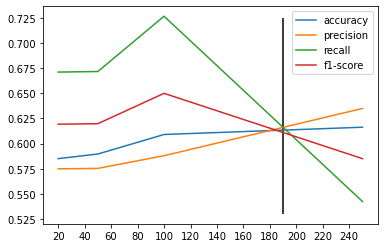

In [236]:
import matplotlib.pyplot as plt
x = [20,50,100,250]
plt.plot(x, accs)
plt.plot(x, precs)
plt.plot(x, recs)
plt.plot(x, f1s)
plt.legend(['accuracy','precision','recall','f1-score'])
plt.xticks(ticks=np.arange(0,260,20))
plt.vlines(190,ymin=0.53, ymax=0.725, color='black')
name = '../plots/'+'metrics_'+str(local_t_size)+'_dims_baseline.png'
plt.savefig(name, dpi=1000)
plt.show()


We note that the optimal number of dimensions seems to lie around **190** as the parameters are at their common highest at this point.